<a href="https://colab.research.google.com/github/nisha-s10/Deep-Learning-Lab-AFI524/blob/main/Experiment%206/Experiment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### STEP 1 – IMPORT LIBRARIES

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import re
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### STEP 2 – LOAD DATASET

In [ ]:
file_path = "spa.txt"

pairs = []
with open(file_path, encoding="utf-8") as f:
    for line in f:
        eng, spa = line.strip().split("\t")
        pairs.append((eng.lower(), spa.lower()))

pairs = pairs[:5000]
print("Total sentence pairs:", len(pairs))

Total sentence pairs: 5000


### STEP 3 — CLEAN TEXT

In [ ]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z¿¡?.!,\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

pairs = [(clean_text(e), clean_text(s)) for e, s in pairs]

### STEP 4 — TRAIN/VAL/TEST SPLIT (80/10/10)

In [ ]:
train_data, temp_data = train_test_split(pairs, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Train: 4000
Validation: 500
Test: 500


### STEP 5 — BUILD VOCABULARY

In [ ]:
def build_vocab(sentences):
    counter = Counter()
    for s in sentences:
        counter.update(s.split())

    vocab = {"<pad>":0, "<sos>":1, "<eos>":2, "<unk>":3}

    for word in counter:
        vocab[word] = len(vocab)

    return vocab

eng_vocab = build_vocab([e for e, s in pairs])
spa_vocab = build_vocab([s for e, s in pairs])

eng_vocab_size = len(eng_vocab)
spa_vocab_size = len(spa_vocab)

### STEP 6 — DATASET + PADDING

In [ ]:
MAX_LEN = 15

class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def encode(self, sentence, vocab):
        tokens = [vocab.get(w, vocab["<unk>"]) for w in sentence.split()]
        tokens = tokens[:MAX_LEN-1]
        tokens.append(vocab["<eos>"])
        tokens += [vocab["<pad>"]] * (MAX_LEN - len(tokens))
        return torch.tensor(tokens)

    def __getitem__(self, idx):
        eng, spa = self.data[idx]

        src = self.encode(eng, eng_vocab)

        trg = [spa_vocab["<sos>"]]
        trg += self.encode(spa, spa_vocab).tolist()
        trg = trg[:MAX_LEN]
        trg += [spa_vocab["<pad>"]] * (MAX_LEN - len(trg))
        trg = torch.tensor(trg)

        return src, trg

    def __len__(self):
        return len(self.data)

train_loader = DataLoader(TranslationDataset(train_data),
                          batch_size=32, shuffle=True)

### VANILLA ENCODER–DECODER (NO ATTENTION)

#### Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

#### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell

### BAHADANAU ATTENTION

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden[-1].unsqueeze(1)
        score = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))
        attention = torch.softmax(self.V(score), dim=1)
        context = torch.sum(attention * encoder_outputs, dim=1)
        return context, attention

### LUONG ATTENTION

In [ ]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden[-1].unsqueeze(2)
        energy = torch.bmm(self.W(encoder_outputs), hidden).squeeze(2)
        attention = torch.softmax(energy, dim=1)
        context = torch.bmm(attention.unsqueeze(1),
                            encoder_outputs).squeeze(1)
        return context, attention

### DECODERS WITH ATTENTION

#### Bahdanau Decoder

In [ ]:
class DecoderBahdanau(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = BahdanauAttention(hidden_dim)
        self.lstm = nn.LSTM(emb_dim + hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell, encoder_outputs):
        x = x.unsqueeze(1)
        embedded = self.embedding(x)
        context, attention = self.attention(hidden, encoder_outputs)
        context = context.unsqueeze(1)
        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell, attention

#### Luong Decoder

In [ ]:
class DecoderLuong(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = LuongAttention(hidden_dim)
        self.lstm = nn.LSTM(emb_dim + hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell, encoder_outputs):
        x = x.unsqueeze(1)
        embedded = self.embedding(x)
        context, attention = self.attention(hidden, encoder_outputs)
        context = context.unsqueeze(1)
        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell, attention

### SEQ2SEQ MODELS

#### Vanilla

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        encoder_outputs, hidden, cell = self.encoder(src)
        input_token = trg[:,0]
        outputs = []

        for t in range(1, MAX_LEN):
            output, hidden, cell = self.decoder(input_token, hidden, cell)
            outputs.append(output)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:,t] if teacher_force else top1

        return torch.stack(outputs, dim=1)

#### Attention Version

In [ ]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        encoder_outputs, hidden, cell = self.encoder(src)
        input_token = trg[:,0]
        outputs = []
        attentions = []

        for t in range(1, MAX_LEN):
            output, hidden, cell, attention = self.decoder(
                input_token, hidden, cell, encoder_outputs)

            outputs.append(output)
            attentions.append(attention)

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:,t] if teacher_force else top1

        return torch.stack(outputs, dim=1), torch.stack(attentions, dim=1)

### TRAINING

In [ ]:
def train_model(model, epochs=25):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    model.train()
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)
            optimizer.zero_grad()

            if isinstance(model, Seq2SeqAttention):
                output, _ = model(src, trg)
            else:
                output = model(src, trg)

            loss = criterion(
                output.reshape(-1, spa_vocab_size),
                trg[:,1:].reshape(-1)
            )

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_loss = total_loss / len(train_loader)
        losses.append(epoch_loss)

        print(f"Epoch {epoch+1} Loss: {epoch_loss}")

    return losses


### TRAIN ALL THREE MODELS

#### Vanilla

Epoch 1 Loss: 5.807947105407715
Epoch 2 Loss: 5.022088157653808
Epoch 3 Loss: 4.846083477020263
Epoch 4 Loss: 4.695938232421875
Epoch 5 Loss: 4.568157411575317
Epoch 6 Loss: 4.464088069915771
Epoch 7 Loss: 4.382917045593262
Epoch 8 Loss: 4.266114641189575
Epoch 9 Loss: 4.155951749801636
Epoch 10 Loss: 4.051179948806762
Epoch 11 Loss: 3.9216040706634523
Epoch 12 Loss: 3.814206573486328
Epoch 13 Loss: 3.6783879947662355
Epoch 14 Loss: 3.586931226730347
Epoch 15 Loss: 3.47557004737854
Epoch 16 Loss: 3.353565155029297
Epoch 17 Loss: 3.2568797874450683
Epoch 18 Loss: 3.124195280075073
Epoch 19 Loss: 3.014044803619385
Epoch 20 Loss: 2.9215872650146486
Epoch 21 Loss: 2.82088959312439
Epoch 22 Loss: 2.7109278564453123
Epoch 23 Loss: 2.612348178863525
Epoch 24 Loss: 2.5006644706726076
Epoch 25 Loss: 2.437173961639404


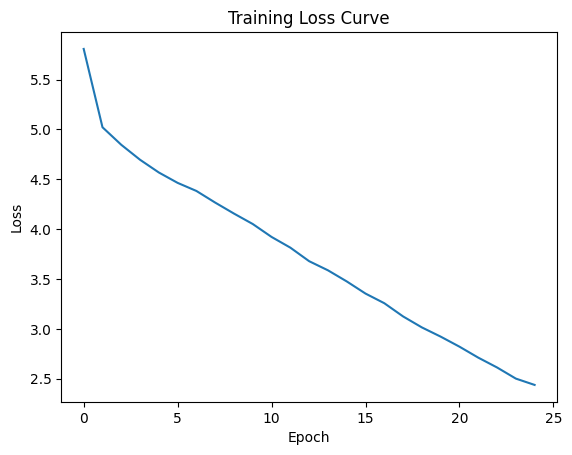

In [ ]:
model_vanilla = Seq2Seq(
    Encoder(eng_vocab_size,128,128),
    Decoder(spa_vocab_size,128,128)
).to(device)

losses = train_model(model_vanilla)

plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#### Bahdanau

Epoch 1 Loss: 5.744249736785888
Epoch 2 Loss: 5.054707473754883
Epoch 3 Loss: 4.863551784515381
Epoch 4 Loss: 4.6727034301757815
Epoch 5 Loss: 4.4917701148986815
Epoch 6 Loss: 4.2960964183807375
Epoch 7 Loss: 4.101015785217285
Epoch 8 Loss: 3.9150235767364503
Epoch 9 Loss: 3.746441286087036
Epoch 10 Loss: 3.568379077911377
Epoch 11 Loss: 3.413766607284546
Epoch 12 Loss: 3.2527976818084716
Epoch 13 Loss: 3.0983515491485596
Epoch 14 Loss: 2.947688142776489
Epoch 15 Loss: 2.7964953022003174
Epoch 16 Loss: 2.6612188205718996
Epoch 17 Loss: 2.5085007038116456
Epoch 18 Loss: 2.3788863096237183
Epoch 19 Loss: 2.278389741897583
Epoch 20 Loss: 2.122718167304993
Epoch 21 Loss: 2.0354550523757933
Epoch 22 Loss: 1.9041730375289918
Epoch 23 Loss: 1.779482533454895
Epoch 24 Loss: 1.6793500289916992
Epoch 25 Loss: 1.5629475917816162


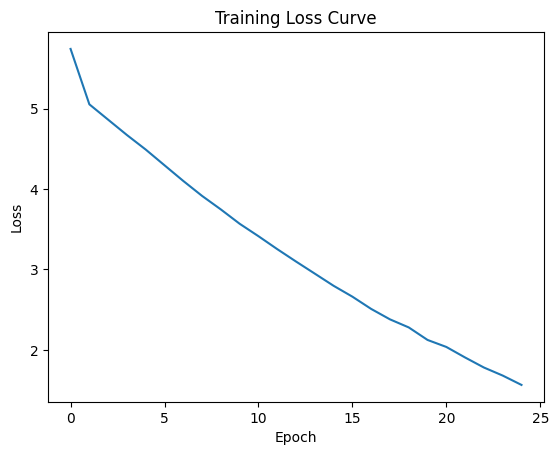

In [ ]:
model_bahdanau = Seq2SeqAttention(
    Encoder(eng_vocab_size,128,128),
    DecoderBahdanau(spa_vocab_size,128,128)
).to(device)

losses = train_model(model_bahdanau)

plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#### Luong

Epoch 1 Loss: 5.515661346435547
Epoch 2 Loss: 4.926740055084228
Epoch 3 Loss: 4.592070373535156
Epoch 4 Loss: 4.358908681869507
Epoch 5 Loss: 4.128801511764526
Epoch 6 Loss: 4.043146551132202
Epoch 7 Loss: 3.975908306121826
Epoch 8 Loss: 3.77169194984436
Epoch 9 Loss: 3.642800931930542
Epoch 10 Loss: 3.4222498474121092
Epoch 11 Loss: 3.24988362121582
Epoch 12 Loss: 3.2156064529418944
Epoch 13 Loss: 2.9714051628112794
Epoch 14 Loss: 2.832880241394043
Epoch 15 Loss: 2.678208758354187
Epoch 16 Loss: 2.4665046796798706
Epoch 17 Loss: 2.369977605819702
Epoch 18 Loss: 2.23494793510437
Epoch 19 Loss: 2.0331009340286257
Epoch 20 Loss: 1.9595872259140015
Epoch 21 Loss: 1.818391489982605
Epoch 22 Loss: 1.659925835609436
Epoch 23 Loss: 1.5491076946258544
Epoch 24 Loss: 1.4671201782226562
Epoch 25 Loss: 1.3667349190711975


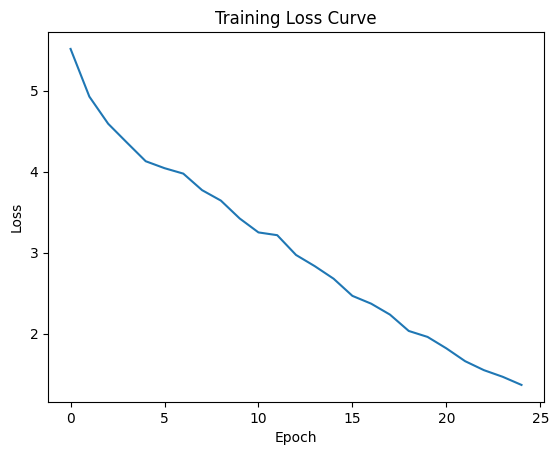

In [ ]:
model_luong = Seq2SeqAttention(
    Encoder(eng_vocab_size,128,512),
    DecoderLuong(spa_vocab_size,256,512)
).to(device)

losses = train_model(model_luong)

plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### BLEU FOR ALL THREE


===== BLEU SCORE COMPARISON =====
Model               BLEU Score
------------------------------
Vanilla LSTM        0.0189
Bahdanau Attention  0.0230
Luong Attention     0.0216


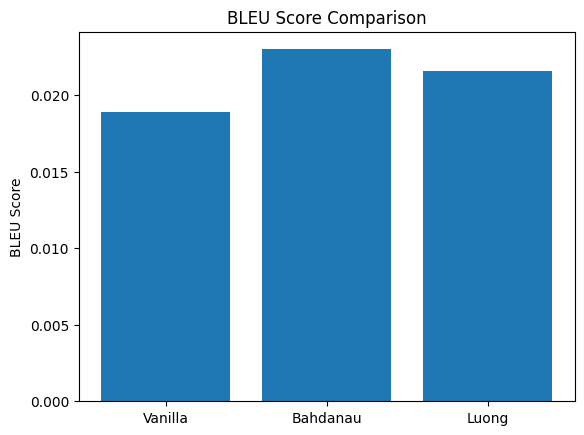

In [ ]:
def evaluate_bleu(model):
    model.eval()
    scores = []
    smooth = SmoothingFunction().method1

    with torch.no_grad():
        dataset = TranslationDataset(test_data)

        for src, trg in dataset:
            src = src.unsqueeze(0).to(device)
            trg = trg.unsqueeze(0).to(device)

            if isinstance(model, Seq2SeqAttention):
                output, _ = model(src, trg, teacher_forcing_ratio=0)
            else:
                output = model(src, trg, teacher_forcing_ratio=0)

            pred = output.argmax(2).squeeze().tolist()
            reference = trg[:,1:].squeeze().tolist()

            score = sentence_bleu(
                [reference],
                pred,
                smoothing_function=smooth
            )

            scores.append(score)

    return np.mean(scores)


bleu_vanilla = evaluate_bleu(model_vanilla)
bleu_bahdanau = evaluate_bleu(model_bahdanau)
bleu_luong = evaluate_bleu(model_luong)

print("\n===== BLEU SCORE COMPARISON =====")
print(f"{'Model':<20}{'BLEU Score'}")
print("-" * 30)
print(f"{'Vanilla LSTM':<20}{bleu_vanilla:.4f}")
print(f"{'Bahdanau Attention':<20}{bleu_bahdanau:.4f}")
print(f"{'Luong Attention':<20}{bleu_luong:.4f}")

models = ["Vanilla", "Bahdanau", "Luong"]
bleu_scores = [bleu_vanilla, bleu_bahdanau, bleu_luong]

plt.bar(models, bleu_scores)
plt.title("BLEU Score Comparison")
plt.ylabel("BLEU Score")
plt.show()

### Visualize BOTH Bahdanau & Luong Attention

#### Helper: Decode tokens to words

In [ ]:
def decode_tokens(tokens, vocab):
    inv_vocab = {v:k for k,v in vocab.items()}
    words = []
    for t in tokens:
        if t == vocab["<eos>"] or t == vocab["<pad>"]:
            break
        words.append(inv_vocab.get(t, "<unk>"))
    return words


#### Bahdanau Visualization

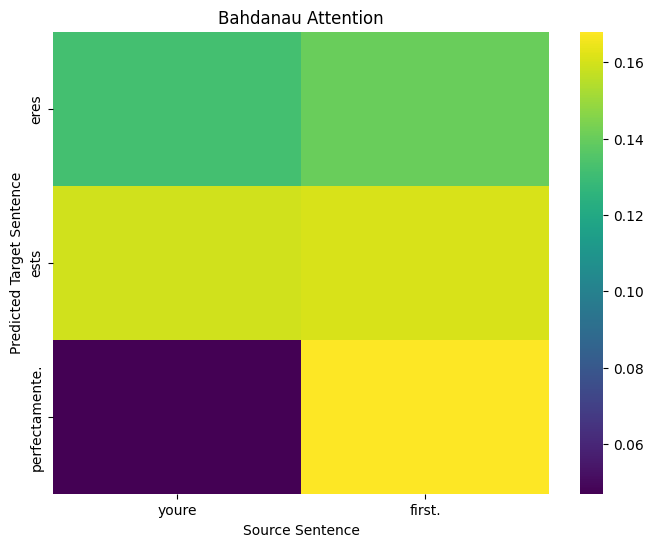

In [ ]:
src, trg = TranslationDataset(test_data)[0]
src_tensor = src.unsqueeze(0).to(device)
trg_tensor = trg.unsqueeze(0).to(device)

output, attention = model_bahdanau(src_tensor, trg_tensor, teacher_forcing_ratio=0)

attention_matrix = attention.squeeze().cpu().detach().numpy()

src_words = decode_tokens(src.tolist(), eng_vocab)
trg_pred = output.argmax(2).squeeze().tolist()
trg_words = decode_tokens(trg_pred, spa_vocab)

plt.figure(figsize=(8,6))
sns.heatmap(attention_matrix[:len(trg_words), :len(src_words)],
            xticklabels=src_words,
            yticklabels=trg_words,
            cmap="viridis")
plt.title("Bahdanau Attention")
plt.xlabel("Source Sentence")
plt.ylabel("Predicted Target Sentence")
plt.show()

#### Luong Visualization

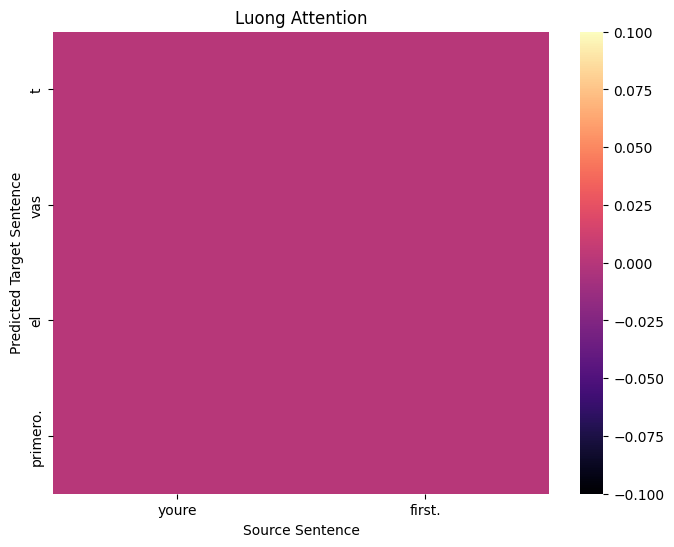

In [ ]:
output_l, attention_l = model_luong(src_tensor, trg_tensor, teacher_forcing_ratio=0)

attention_matrix_l = attention_l.squeeze().cpu().detach().numpy()

trg_pred_l = output_l.argmax(2).squeeze().tolist()
trg_words_l = decode_tokens(trg_pred_l, spa_vocab)

plt.figure(figsize=(8,6))
sns.heatmap(attention_matrix_l[:len(trg_words_l), :len(src_words)],
            xticklabels=src_words,
            yticklabels=trg_words_l,
            cmap="magma")
plt.title("Luong Attention")
plt.xlabel("Source Sentence")
plt.ylabel("Predicted Target Sentence")
plt.show()

### Example Translation Outputs (All Models)

In [ ]:
def translate_sentence(model, sentence):
    model.eval()

    dataset = TranslationDataset([(sentence, "")])
    src, _ = dataset[0]
    src = src.unsqueeze(0).to(device)

    dummy_trg = torch.zeros((1, MAX_LEN), dtype=torch.long).to(device)

    with torch.no_grad():
        if isinstance(model, Seq2SeqAttention):
            output, _ = model(src, dummy_trg, teacher_forcing_ratio=0)
        else:
            output = model(src, dummy_trg, teacher_forcing_ratio=0)

    pred_tokens = output.argmax(2).squeeze().tolist()
    return " ".join(decode_tokens(pred_tokens, spa_vocab))

example_sentence = test_data[0][0]

print("Source:", example_sentence)
print("\nVanilla:", translate_sentence(model_vanilla, example_sentence))
print("\nBahdanau:", translate_sentence(model_bahdanau, example_sentence))
print("\nLuong:", translate_sentence(model_luong, example_sentence))

Source: youre first.

Vanilla: por favor.

Bahdanau: ests retrasado.

Luong: t primero.
